In [30]:
import os
import numpy as np
import torch
import torch.nn as nn

import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt

%matplotlib inline

In [31]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [56]:
data_dir = '../input/building-type/staticmap/'

batch_size = 16
valid_size = 0.20

random_transforms = [transforms.RandomRotation(20),
                                       transforms.RandomHorizontalFlip()]
train_transforms = transforms.Compose([transforms.Resize((224, 224)),
                                 transforms.RandomApply(random_transforms, p=0.3),
                                 transforms.ToTensor(),
                                 transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
test_transforms = transforms.Compose([transforms.Resize((224, 224)),
                                 transforms.ToTensor()])

train_data = datasets.ImageFolder(data_dir + 'train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + 'test', transform=test_transforms)

num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler)
validloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
    sampler=valid_sampler)
testloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

# Output classes
output_classes = ['residential', 'industrial']

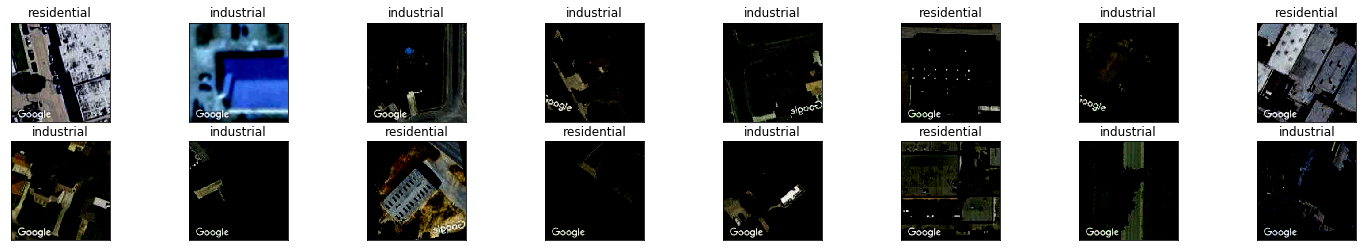

In [57]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(16):
    ax = fig.add_subplot(2, 16/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(output_classes[labels[idx]])

In [61]:
vgg19 = models.vgg19(pretrained=True)

# print out the model structure
print(vgg19)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [62]:
for param in vgg19.features.parameters():
    param.requires_grad = False

In [63]:
n_inputs = vgg19.classifier[6].in_features

from collections import OrderedDict
fc_layer = nn.Linear(n_inputs, 2, bias = True)

vgg19.classifier[6] = fc_layer

print(vgg19)

# if GPU is available, move the model to GPU
if train_on_gpu:
    vgg19.cuda()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [64]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(vgg19.classifier.parameters(), lr=0.003)

In [65]:
# number of epochs to train the model
n_epochs = 40

valid_loss_min = np.Inf

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    vgg19.train()
    for data, target in trainloader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
 
        optimizer.zero_grad()
        output = vgg19(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)

    vgg19.eval()
    for data, target in validloader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        output = vgg19(data)
        loss = criterion(output, target)
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(trainloader.dataset)
    valid_loss = valid_loss/len(validloader.dataset)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(vgg19.state_dict(), 'binary_classification.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 2.732644 	Validation Loss: 0.690330
Validation loss decreased (inf --> 0.690330).  Saving model ...
Epoch: 2 	Training Loss: 1.733337 	Validation Loss: 0.650943
Validation loss decreased (0.690330 --> 0.650943).  Saving model ...
Epoch: 3 	Training Loss: 2.313310 	Validation Loss: 0.328252
Validation loss decreased (0.650943 --> 0.328252).  Saving model ...
Epoch: 4 	Training Loss: 2.416057 	Validation Loss: 0.252370
Validation loss decreased (0.328252 --> 0.252370).  Saving model ...
Epoch: 5 	Training Loss: 2.442847 	Validation Loss: 0.413343
Epoch: 6 	Training Loss: 3.735216 	Validation Loss: 0.431803
Epoch: 7 	Training Loss: 4.101389 	Validation Loss: 1.495608
Epoch: 8 	Training Loss: 6.313090 	Validation Loss: 2.391201
Epoch: 9 	Training Loss: 5.507923 	Validation Loss: 0.543248
Epoch: 10 	Training Loss: 4.120221 	Validation Loss: 0.477503
Epoch: 11 	Training Loss: 3.417497 	Validation Loss: 0.506038
Epoch: 12 	Training Loss: 2.998890 	Validation Loss: 0.5

In [66]:
vgg19.load_state_dict(torch.load('binary_classification.pt'))

<All keys matched successfully>

In [67]:
test_loss = 0.0
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))

vgg19.eval() # eval mode

# iterate over test data
for data, target in testloader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    output = vgg19(data)
    loss = criterion(output, target)
    test_loss += loss.item()*data.size(0)
    _, pred = torch.max(output, 1)
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    for i in range(target.size(0)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate avg test loss
test_loss = test_loss/len(testloader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(2):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            output_classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (output_classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 1.567436

Test Accuracy of residential: 86% (130/150)
Test Accuracy of industrial: 84% (127/150)

Test Accuracy (Overall): 85% (257/300)


In [68]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

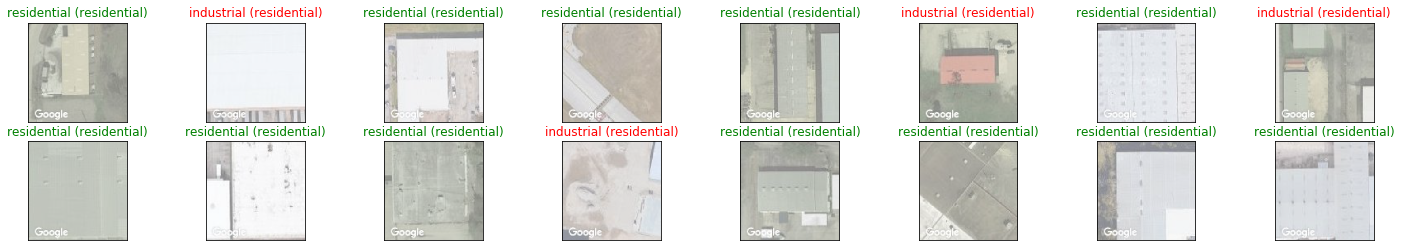

In [70]:
# obtain one batch of test images
dataiter = iter(testloader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = vgg19(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(16):
    ax = fig.add_subplot(2, 16/2, idx+1, xticks=[], yticks=[])
    imshow(images.cpu()[idx])
    ax.set_title("{} ({})".format(output_classes[preds[idx]], output_classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))